# Explanation and Verfication of Data Processing Steps
This notebook serves two main purposes:
1. Describe the data processing steps done to the data
2. Validate/audit the data at each step to ensure that they are no errors in the processing. Because of this
I use the file **sms-verification.xml** for all the processing in this notebook.

In [1]:
# import the pypower package and others
import sys
import os
import time
from datetime import datetime
# add our main processing modules to python path, so we can easily import them
sys.path.append('/Users/dmatekenya/Google-Drive/worldbank/smart-survey-boxes/code')
import pandas as pd
import numpy as np
import operator

# pypower
%matplotlib inline
import matplotlib.pyplot as plt
from data_processing import data_processing_utils as util
from data_processing import data_processing_engine as dp

# Plotting
from IPython.display import Image

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# some global variables
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'

## Naming Conventions and Important folders
The root folder where all work outputs are saved is **OneDrive/William Hutchins Seitz-01.Electricity_monitoring/**. Selected utputs (e.g., model evaluation plots) from the data processing
I do can be found in **./outputs_from_dunstan_data_processing**. All the data are saved in **./01.data**. Within this data folder, there are a couple of important subfolders as follows:

* processed-sms
   * sms_observed.csv: contains both valid and invalid sms events. Definition of valid can be found in the later sections of this document
   * sms_observed_valid.csv: Has only valid events.
   * sms_rect_hr.csv: Rectangularised valid events with missing event labeled
   * sms_rect_hr_imputed.csv: Same as above but with missing events imputed.
* raw-sms-backup: Daily backup of sms.xml
* imputation-verification: Derived datasets for checking sanity of the imputation are saved here
* spatial-data: I save all geograpgic datasets here
* tableau-inputs: If there is need to create specific tableau inputs, they are kept here
 

They are two other source folders to take note of:
- **SharedGoogDrive/SMSBuckupRestore :** As everyone is aware, this contains the sms.xml file which is updated everyday
- **SharedGoogDrive/smart-survey-boxes :** I shared this Google-Drive folder. It contains all the work I do. Specifically, the code I use is in the **./code**. This is the code which is being used to process the data, although the data is save in William OneDrive folder.

In [2]:
# set up environment
data_folder, xml_folder, outputs_folder = None, None, None
if sys.platform == 'darwin':
    data_folder = os.path.abspath('/Users/dmatekenya/Google-Drive/worldbank/smart-survey-boxes/data')
    xml_folder = os.path.abspath("/Users/dmatekenya/Google-Drive/SMSBuckupRestore/")
    outputs_folder = os.path.abspath('/Users/dmatekenya/Google-Drive/worldbank/smart-survey-boxes/outputs')

if sys.platform == 'win32':
    # windows-onedrive
    data_folder = os.path.normpath(os.path.abspath("C:/Users/wb344850/WBG/William Hutchins Seitz - 01.data/"))
    xml_folder = os.path.normpath(os.path.abspath("C:/Users/wb344850/Google-Drive/SMSBuckupRestore/"))
    outputs_folder = os.path.normpath(os.path.abspath("C:/Users/wb344850/Google-Drive/worldbank/smart-survey-boxes/outputs"))

## Raw sms data back up
The *sms.xml* is is converted to *sms.csv* everyday. This is set up using 

windows scheduler on my windows bank computer. There is no processing done

to the data in this process. The sms files are saved with a date suffix.

In [10]:
# ======== DATA BACK-UP   ==========================
# Initiate a data processor object
data_processor_params = {'data_dir': data_folder, 'process_type': 'backup', 'verification_mode': False,
                             'debug_mode': True, 'xml_dir': xml_folder, 'outputs_dir': outputs_folder,
                             'box_dist_ver': 14}

data_processor = dp.DataProcessor(**data_processor_params)
data_processor.process_data()

XML==>CSV conversion started.....

 Converting sms events in xml file to python dict .....
The record below was excluded because it doesnt look like an event...
[('count', '440661'), ('backup_set', '67852a41-2131-4208-812b-16a941dac31c'), ('backup_date', '1521226802037')]
About this xml file==> Date last modified: Fri Mar 16 15:34:42 2018
Number of events in this sms.xml: 440,661
Event attributes are shown below...
['protocol', 'address', 'date', 'type', 'subject', 'body', 'toa', 'sc_toa']
['service_center', 'read', 'status', 'locked', 'date_sent', 'readable_date', 'contact_name']

XML==>CSV conversion finished.


### Verify that the data is indeed intact
We check the data which is saved with today date.

In [5]:
# We get latest file in the raw-sms-backup directory
backup_dir = data_processor.raw_data_dir  # this will be replaced by 
data_files = [f for f in os.listdir(backup_dir) if os.path.isfile(os.path.join(backup_dir, f))]
file_time = {}

for f in data_files:
    if f[-3:] == 'csv':
        full_path = os.path.join(backup_dir, f)
        last_update = os.path.getmtime(full_path)
        file_time[last_update] = full_path
        
sorted_x = sorted(file_time.items(), key=operator.itemgetter(0), reverse=True)
latest_csv_file = sorted_x[0][1]

# Now lets check the csv file to make sure its the same as the xml file
df = pd.read_csv(latest_csv_file, low_memory=False)
print('Number of events in this sms.xml: {:,}'.format(df.shape[0]))
print('Event attributes...')
cols = list(df.columns)
print(cols[:8])
print(cols[8:])

Number of events in this sms.xml: 440,639
Event attributes...
['protocol', 'address', 'date', 'type', 'subject', 'body', 'toa', 'sc_toa']
['service_center', 'read', 'status', 'locked', 'date_sent', 'readable_date', 'contact_name']


## Process sms data
This is the first processing step. During this step, the main processing done are as follows:
- Fixing dates
- Setting attributes for events
- etc.

Each event is given many attributes as shown in figure below. After all the processing, 
here are the outputs data files:
1. sms_observed.csv: contains all sms events including the invalid ones. Invalid events are those which satisfy the following condition: test message, no device id in message body, impssoible to generate message type from message or event occured before start date of data collection.

2. sms_observed_valid.csv: keep only the valid events

3. sms_rect_hr.csv: Based on only valid events, create rectangular dataset.

 EVENT ATTRIBUTES


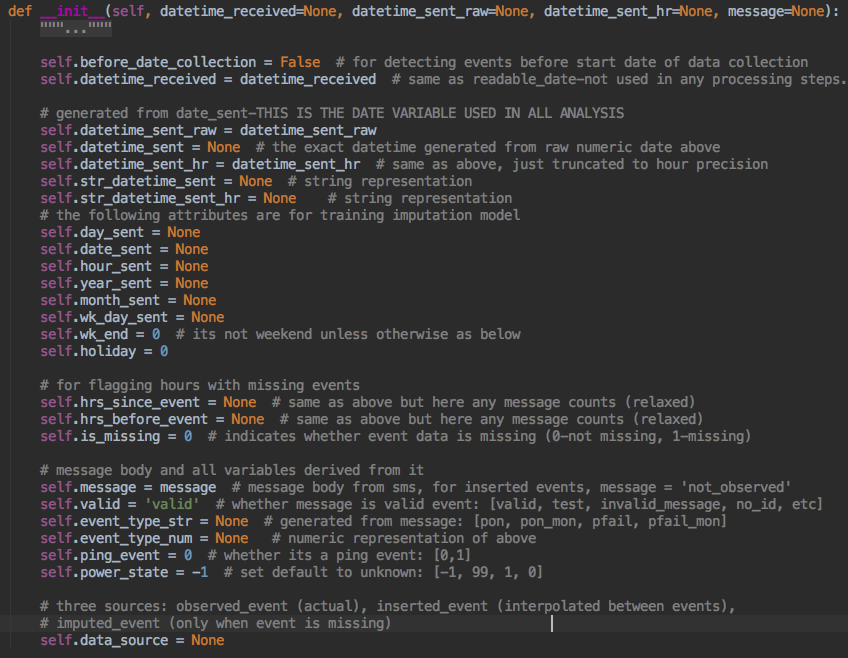

In [6]:
print('====================')
print(' EVENT ATTRIBUTES')
print('====================')
Image(filename='/Users/dmatekenya/Google-Drive/worldbank/smart-survey-boxes/' +
      'outputs/data-processing-documentation/event_attr.png')

## Check the processed data outputs

In [9]:
# Location processed data files
processed_sms =  data_processor.processed_data_dir
observed = os.path.join(processed_sms, 'sms_observed.csv')
observed_valid = os.path.join(processed_sms, 'sms_observed_valid.csv')
rect =  os.path.join(processed_sms, 'sms_rect_hr.csv')
rect_imp = os.path.join(processed_sms, 'sms_rect_hr_imputed.csv')
outage_sum_comp = os.path.join(processed_sms, 'outage_summary_comparison.csv')

# Read into data frame
df_observed = pd.read_csv(observed)
df_observed_valid = pd.read_csv(observed_valid)
df_rect = pd.read_csv(rect)
df_imp = pd.read_csv(rect_imp)
# df_sum_comp = pd.read_csv(outage_sum_comp)

In [ ]:
df_observed_valid.shape

In [ ]:
df_rect.power_state.value_counts(normalize=True)

### A few things to note about sms_rect_hr
As can be seen above, [99] is for invalid and should be dropped from analysis.

In [ ]:
df_rect[['box_id','event_type_str', 'power_state', 'data_source', 'str_datetime_sent','str_datetime_sent_hr' ]][:25]

#### Check if number of events after processing matches with original number of events

In [ ]:
# Number of events in observed.csv
print ('Number of events in observed.csv: {:,}'.format(df_observed.shape[0]))

### Examine invalid events

In [ ]:
df_observed.valid.value_counts()

In [ ]:
def detect_test_events(str):
    if 'test' in str:
        return 1
    
    return 0

** How many of the invalid are test events?**

We see that the number of test events matches with what is in the stata data.

In [ ]:
df_observed['test'] = df_observed['valid'].apply(lambda x: detect_test_events(x))
df_observed['test'].value_counts()

In [ ]:
Image(filename='/Users/dmatekenya/Google-Drive/worldbank/smart-survey-boxes/' +
      'outputs/data-processing-documentation/stata_test_events.png')

** How many sms with no device-id?**

Again here, number of events with no id is same as in in stata code data.

In [ ]:
def detect_no_id_events(str):
    if 'no-device-id' in str:
        return 1
    
    return 0

In [ ]:
df_observed['no_id'] = df_observed['valid'].apply(lambda x: detect_no_id_events(x))
df_observed['no_id'].value_counts()

** The dataset from here doesnt necessarily match the one generated from stata from here onwards due mainly to before-date-of-collection**


In [ ]:
def detect_before_start_of_collection(str):
    if 'before-date-of-collection' in str:
        return 1
    
    return 0

In [ ]:
df_observed['before_start'] = df_observed['valid'].apply(lambda x: detect_before_start_of_collection(x))
df_observed['before_start'].value_counts()

df_before_start = df_observed.groupby(['box_id','before_start']).count().reset_index()
df_before_start = df_before_start[df_before_start.before_start == 1]
df_before_start = df_before_start[['box_id', 'before_start','region']]
df_before_start.rename(columns={'region': 'count'}, inplace=True)
df_before_start.sort_values(by='count', ascending=False, inplace=True)
print('='*70)
print('Top 10 boxes with events which occurred before collection started')
print('='*70)
df_before_start[:10]

### Examine missing and invalid values
A detailed description of how hours are flagged as being missing or not can be found in the documentation.
A function which was used to flag events is shown below. As for the values:
**power state: ** [1:power on, 0:power off, -1:missing, 99:invalid]. 
Given this coding scheme, all invalid values events are omitted when training model for imputation.
Also, they should be omitted in any analysis.

In [ ]:
Image(filename='/Users/dmatekenya/Google-Drive/worldbank/smart-survey-boxes/' +
      'outputs/data-processing-documentation/flagging_missing_values.png')

** The number of missing values can be seen below**

In [ ]:
df_rect.power_state.value_counts()

** After imputation, they are no missing values. Invalid values are maintained for verification**

In [ ]:
df_imp.power_state.value_counts()

In [ ]:
df_imp.data_source.value_counts()

## How missing values are being flagged

Illustrate the process of flagging missing values with a few boxes. We take a single box (id = 1301).

** Select box-id 1301 **

In [ ]:
# create a single box objects to illustrate/verify the process of flagging missing events
bx_1301 = df_observed_valid[df_observed_valid.box_id == 1301]
bx_1301['datetime_sent'] = bx_1301.apply(lambda x: datetime.strptime(x['str_datetime_sent'], TIME_FORMAT), axis=1)
bx_1301 = bx_1301.sort_values(by='datetime_sent')
cols = ['box_id', 'datetime_sent', 'str_datetime_sent_hr', 'event_type_str',
       'power_state', 'data_source']

** Below I'm just replicating the processing I do in the automated procedure **

In [ ]:
# A class for holding all characteristics of a box, note that box id = 1301
time_format = '%Y-%m-%d %H:%M:%S'
box_obj = util.Box(date_collection_started=bx_1301['date_collection_started'],box_id=1301, psu=bx_1301['psu'].iloc[0], 
              lon=bx_1301['lon'].iloc[0], urban_rural=bx_1301['urban_rural'].iloc[0], lat=bx_1301['lat'].iloc[0], 
              district=bx_1301['district'].iloc[0], region=bx_1301['region'].iloc[0])

# Add events to this box, note that some event attributes are skipped here
for index, item in bx_1301.iterrows():
    # create an event object with core attributes
    event = util.Event(datetime_sent_raw=item['str_datetime_sent'],
                      message='None')
    # set all important attributes
    event.datetime_sent = datetime.strptime(item['str_datetime_sent'], time_format)
    event.event_type_str = item['event_type_str']
    event.valid = 'valid'
    event.power_state = item['power_state']
    event.datetime_sent_hr = datetime.strptime(item['str_datetime_sent_hr'], time_format)
    
    # indicate data source
    event.data_source = 'observed_event'
    box_obj.add_event(event)

# Keep only columns we need
bx_1301 = bx_1301[cols]

** In order to judge how many *missing* values we should expect, lets add a time interval.
This is the interval between 2 observed events, which is essentially what dtermines how many missing values we will have.**

In [ ]:
def add_time_interval_col(df = None, time_col = None, time_interval_col_name=None):
    """
    Add time interval column to a df
    """
    # check if time-col is string, change it to date
    if isinstance(df[time_col].iloc[0], str):
        df[time_col] = df[time_col].apply(lambda x: datetime.strptime(x, TIME_FORMAT ))
        
    df2 = df.set_index(time_col)
    df2[time_col] = df2.index
    
    # sort by index and calculate time interval
    df2.sort_values(by=time_col, inplace=True)
    
    df2['interval'] = (df2[time_col]-df2[time_col].shift()).fillna(0)
    
    # convert to hours
    df2[time_interval_col_name] = df2['interval'].apply(lambda x: x.total_seconds()/3600)
    
    return df2

In [ ]:
# add time-interval column
bx_1301 = add_time_interval_col(df = bx_1301, time_col='datetime_sent', time_interval_col_name='interval_hrs')

** Below is a summary of the interval variable**

In [ ]:
bx_1301['interval_hrs'].describe()

** Now, lets turn to the automated procedure, rectangularise the dataset and see 
how many missing values we get**

In [ ]:
box_obj.generate_hourly_events_based_on_power_state(after_event_threshold=13,invalid_threshold=72)
box_metadata = box_obj.get_box_metadata(required_box_metadata_lst=['box_id','region', 'district', 'urban_rural','psu', 'lon', 'lat'])

columns = ['box_id', 'datetime_sent', 'str_datetime_sent_hr', 'event_type_str', 'power_state', 'data_source']
hr_events_metadata = []

for eve in box_obj.hourly_events.values():
    event_attr = eve.get_selected_event_metadata()
    event_attr.update(box_metadata)
    hr_events_metadata.append(event_attr)

# create dataframe
df = pd.DataFrame(hr_events_metadata)

# sort by datetime_sent
df.sort_values(by='datetime_sent', inplace=True)

# reorder columns
bx_1301_auto = df[columns]

** Lets add time passed from observed event, compare with flagged missing values and see if its working as it should be.**

In [ ]:
# add variable which will hold time_after_previous_event
bx_1301_auto['time_after_prev'] = None

# keep observed event date at whenever it aperas
observed_event_time = bx_1301_auto['datetime_sent'].iloc[0]

# Not a very neat way to handle this
index_time_dict = {}

for index, row in bx_1301_auto.iterrows():
    if  row['data_source'] == 'observed_event':
        observed_event_time = row['datetime_sent']
    
    #current event time
    current_event_time = row['datetime_sent']
    
    # Time difference between current event and previous observed event (hrs)
    time_interval = (current_event_time-observed_event_time).total_seconds()/3600
    
    # set 'time_after_prev'
    index_time_dict[index] = time_interval

bx_1301_auto['time_after_prev'] = bx_1301_auto.apply(lambda x: index_time_dict[x.name], axis=1)

In [ ]:
print('Take a look at the output')
bx_1301_auto.head(25)

** We can see below that missing is only appearing in hours which are greater than 13 hrs after observed event**

In [ ]:
bx_1301_auto[bx_1301_auto.power_state == -1][:25]

# Comparing statistics between imputed and unimputed datasets
A few details about the process as below:
- The variable being used is **daily average outage duration**.
- This variable was computed for *sms_rect_hr.csv* [actual] and *sms_rect_hr_imputed.csv* [imputed]
- The computation is done by first counting daily outage hours within a box to come up with 
*daily_outage_duration_actual.csv* and then averaging average across boxes for each day to get *outage_summary_comparison.csv* which has summaries for both **actual** and **imputed**
- Results of comparing the **actual** vs. **imputed** are shown below

In [ ]:
print("First 10 rows of the comparison ...")
df_sum_comp.head(10)

In [ ]:
print('======================================')
print(' IMPUTED DATASET VS. ACTUAL DATASET')
print('======================================')
Image(filename='/Users/dmatekenya/Google-Drive/worldbank/smart-survey-boxes/' +
      'outputs/data-processing-documentation/outage_summary_comparison.png')

In [ ]:
def summarise_outage_counts_from_stata_powerout_file()

In [ ]:
df.dtypespes

In [4]:
file = os.path.join(data_folder, 'powerout.csv')
# df = pd.read_csv(file)
# df = df[df.POWERout == 1]  # keep only power_off events
# df['date_sent'] = df['date_powerfailure'].apply(lambda x: datetime.strptime(x, '%d%b%Y'))
# # df.rename(columns={'BoxID': 'box_id', 'POWERout':'power_off','dhms':'datetime_sent',
# #                    'date_powerfailure_hour':'hour_sent'}, inplace=True)
# # df = df[['box_id', 'power_off', 'date_sent', 'hour_sent', 'datetime_sent']]

In [5]:
df_sum = util.summarise_outage_counts_from_stata_powerout_file(powerout_file=file)

In [6]:
df_sum.head()

,date_sent,hrs_power_off,hrs_power_off_10pm,box_id
0,2016-11-26,8.0,0,1001
1,2016-11-26,8.0,5,1001
2,2016-11-27,24.0,0,1001
3,2016-11-27,24.0,5,1001
4,2016-11-28,17.0,0,1001


In [7]:
df_sum.shape

(57989, 4)

In [11]:
df_grp = util.calculate_daily_average_power_out(df=df_sum, var='hrs_power_off')

In [12]:
df_grp.head()

,day,date_sent,avg_hrs_power_off
0,1,2016-10-25,11.600000
1,2,2016-10-26,11.470588
2,3,2016-10-27,13.850000
3,4,2016-10-28,15.677419
4,5,2016-10-29,14.565217


In [126]:
df_observed_valid = pd.read_csv(observed_valid, parse_dates=['str_datetime_sent', 'str_datetime_sent_hr'])

In [129]:
df_observed_valid.str_datetime_sent.value_counts(normalize=True)

2017-01-15 19:22:50    0.000038
2017-01-12 07:30:19    0.000038
2017-07-14 20:18:34    0.000036
2017-01-12 07:30:18    0.000036
2017-09-05 18:09:40    0.000031
2017-05-15 09:32:58    0.000031
2016-12-21 08:11:48    0.000028
2017-04-27 14:53:38    0.000028
2017-01-15 17:17:43    0.000028
2017-07-16 10:12:57    0.000028
2017-01-15 17:17:45    0.000028
2017-03-30 06:40:07    0.000028
2017-08-03 20:07:33    0.000028
2017-02-16 17:29:41    0.000028
2017-04-20 16:43:47    0.000026
2017-08-03 19:59:15    0.000026
2017-07-16 10:12:59    0.000026
2017-07-16 10:12:56    0.000026
2017-08-03 19:59:19    0.000026
2017-03-15 10:08:56    0.000026
2017-11-24 12:55:29    0.000026
2016-12-21 08:11:45    0.000026
2017-05-10 04:52:35    0.000026
2017-11-10 17:05:50    0.000023
2017-01-12 08:03:05    0.000023
2017-03-18 09:30:31    0.000023
2017-11-24 15:04:17    0.000023
2017-11-10 17:20:50    0.000023
2018-01-06 15:23:49    0.000023
2017-11-10 17:06:53    0.000023
                         ...   
2016-11-

In [ ]:
def generate_powerout_duration_file(df=None):
    """
    Create powerout.csv for tableau
    """
    cols_to_keep = ['box_id', 'date_collection_started', 'date_sent',
       'str_datetime_sent', 'str_datetime_sent_hr', 'event_type_str', 'power_state', 'data_source']
    df = df[cols_to_keep]
    
    df = df[df['event_type_str'].isin(['pfail','pback'])]
    
    # sort by datetime
    df = df.sort_values(by=['str_datetime_sent'], inplace=True)
    
    # Normalise the data to keep only valid pfail, pback events
    
    
    
    

In [77]:
def normalise_power_out_events(df=None):
    
    lst_events = [df.iloc[i] for i in range(len(df))] 

    grped_lst_events = list(group(lst=lst_events,n=2))

    total_power_out_events = len(grped_lst_events )

    invalid_power_out_events = 0

    new_event_list = []

    for i in grped_lst_events:
        event_1 = i[0]
        event_2 = i[1]
        event_str = event_1.event_type_str + '-' + event_2.event_type_str
        if event_str == 'pfail-pback':
            new_event_list = new_event_list + [event_1, event_2]
        else:
            invalid_power_out_events += 1
            continue
    
    return invalid_power_out_events, pd.DataFrame(new_event_list)

In [19]:
test_box = df_observed_valid[df_observed_valid.box_id == 1301]


In [20]:
cols_to_keep = ['box_id', 'date_collection_started', 'date_sent',
       'str_datetime_sent', 'str_datetime_sent_hr', 'event_type_str', 'power_state', 'data_source']

In [21]:
test_box = test_box[cols_to_keep]
test_box

In [23]:
# keep only pfail and pback events
test_box = test_box[test_box['event_type_str'].isin(['pfail','pback'])]
test_box.event_type_str.value_counts()

pfail    355
pback    298
Name: event_type_str, dtype: int64

In [24]:
test_box.sort_values(by=['str_datetime_sent'], inplace=True)

In [25]:
test_box.head()

,box_id,date_collection_started,date_sent,str_datetime_sent,str_datetime_sent_hr,event_type_str,power_state,data_source
46,1301,2016-11-08,2016-10-21,2016-10-21 15:53:12,2016-10-21 15:00:00,pback,1,observed_event
47,1301,2016-11-08,2016-10-21,2016-10-21 15:53:27,2016-10-21 15:00:00,pfail,0,observed_event
48,1301,2016-11-08,2016-10-21,2016-10-21 18:19:00,2016-10-21 18:00:00,pback,1,observed_event
49,1301,2016-11-08,2016-10-21,2016-10-21 18:19:43,2016-10-21 18:00:00,pfail,0,observed_event
53,1301,2016-11-08,2016-11-08,2016-11-08 17:52:45,2016-11-08 17:00:00,pback,1,observed_event


In [29]:
def group(lst=None, n=None):
    """group([0,3,4,10,2,3], 2) => [(0,3), (4,10), (2,3)]
    
    Group a list into consecutive n-tuples. Incomplete tuples are
    discarded e.g.
    
    >>> group(range(10), 3)
    [(0, 1, 2), (3, 4, 5), (6, 7, 8)]
    """
    return zip(*[lst[i::n] for i in range(n)])

In [70]:
lst_events = [df.iloc[i] for i in range(len(df))] 

grped_lst_events = list(group(lst=lst_events,n=2))

total_power_out_events = len(grped_lst_events )

invalid_power_out_events = 0

new_event_list = []

for i in grped_lst_events:
    event_1 = i[0]
    event_2 = i[1]
    event_str = event_1.event_type_str + '-' + event_2.event_type_str
    if event_str == 'pfail-pback':
        new_event_list = new_event_list + [event_1, event_2]
    else:
        invalid_power_out_events += 1
        continue
        

NameError: name 'df' is not defined

In [48]:
lst = [test_box.iloc[i] for i in range(len(test_box))] 

In [55]:
lst[0]

box_id                                    1301
date_collection_started             2016-11-08
date_sent                           2016-10-21
str_datetime_sent          2016-10-21 15:53:12
str_datetime_sent_hr       2016-10-21 15:00:00
event_type_str                           pback
power_state                                  1
data_source                     observed_event
Name: 46, dtype: object

In [57]:
grouped_lst = list(group(lst,n=2))

In [58]:
len(grouped_lst)

326

In [79]:
invalid, df = normalise_power_out_events(df=test_box)
invalid2, df2 = normalise_power_out_events(df=df)

In [84]:
df_pout = pd.read_csv(data_folder + '/powerout.csv')

In [85]:
df_pout.head()

,BoxID,date_powerfailure,date_powerfailure_hour,date_powerback,date_powerback_hour,DateCollectionStart,duration,delivered,_fillin,POWERout,dhms,checks,_merge
0,1001,25oct2016,0.0,NaN,NaN,NaN,NaN,NaN,1,0.0,25oct2016 00:00:00,-9,1
1,1001,25oct2016,1.0,NaN,NaN,NaN,NaN,NaN,1,0.0,25oct2016 01:00:00,-9,1
2,1001,25oct2016,2.0,NaN,NaN,NaN,NaN,NaN,1,0.0,25oct2016 02:00:00,-9,1
3,1001,25oct2016,3.0,NaN,NaN,NaN,NaN,NaN,1,0.0,25oct2016 03:00:00,-9,1
4,1001,25oct2016,4.0,NaN,NaN,NaN,NaN,NaN,1,0.0,25oct2016 04:00:00,-9,1


In [86]:
df_pout.POWERout.value_counts()

0.0    2866461
1.0     322904
Name: POWERout, dtype: int64

In [87]:
df_pout.shape

(3191163, 13)

In [125]:
def add_time_interval(df=None, datetime_col=None):
    """
    Given a sorted dataframe, adds a time interval column
    """
    df['tdiff'] = (df[datetime_col]-df[datetime_col].shift()).fillna(0)
    
    df['duration_minutes'] = df['tdiff'].apply(lambda r: r.total_seconds()/60)
    
    
    return df

In [118]:
def powerout_duration_with_invalid(in_df=None, date_col=None):
    """
    :param df: Dataframe of pfail and pback events sorted by time
    """
    # Just ensure that first event isnt pback: thats the only check we do
    if in_df.iloc[0].event_type_str == 'pback':
        in_df = in_df[1:]

    # add time-interval
    df_with_intervals = add_time_interval(df=in_df,  datetime_col=date_col)
    
    return df_with_intervals 
    

In [122]:
def generate_powerout_duration(df=None, exclude_invalid_powerout_events=False, time_col='str_datetime_sent'):
    """
    Create powerout.csv for tableau
    """
    df = df[df['event_type_str'].isin(['pfail','pback'])]
    sorted_df = df.sort_values(by=[time_col])
    
    if exclude_invalid_powerout_events:
        df_with_intervals = powerout_duration_with_valid_powerout_events()
    else:
        df_with_intervals = powerout_duration_with_invalid(in_df=sorted_df, date_col=time_col)
    
    return df_with_intervals

In [123]:
cols_to_keep = ['box_id', 'date_collection_started', 'date_sent',
       'str_datetime_sent', 'str_datetime_sent_hr', 'event_type_str', 'power_state', 'data_source']
df_observed_valid = df_observed_valid[cols_to_keep]
test_box = df_observed_valid[df_observed_valid.box_id == 1301]
test_box_intervals = generate_powerout_duration(df=test_box, exclude_invalid_powerout_events=False, time_col='str_datetime_sent')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [124]:
test_box_intervals.head()

,box_id,date_collection_started,date_sent,str_datetime_sent,str_datetime_sent_hr,event_type_str,power_state,data_source,tdiff,tdiff_minutes
47,1301,2016-11-08,2016-10-21,2016-10-21 15:53:27,2016-10-21 15:00:00,pfail,0,observed_event,0 days 00:00:00,0.000000
48,1301,2016-11-08,2016-10-21,2016-10-21 18:19:00,2016-10-21 18:00:00,pback,1,observed_event,0 days 02:25:33,145.550000
49,1301,2016-11-08,2016-10-21,2016-10-21 18:19:43,2016-10-21 18:00:00,pfail,0,observed_event,0 days 00:00:43,0.716667
53,1301,2016-11-08,2016-11-08,2016-11-08 17:52:45,2016-11-08 17:00:00,pback,1,observed_event,17 days 23:33:02,25893.033333
54,1301,2016-11-08,2016-11-08,2016-11-08 21:12:36,2016-11-08 21:00:00,pfail,0,observed_event,0 days 03:19:51,199.850000


In [105]:
test_box.columns

Index(['box_id', 'region', 'district', 'urban_rural', 'psu', 'lon', 'lat',
       'date_collection_started', 'datetime_sent_raw', 'date_sent',
       'str_datetime_sent', 'str_datetime_sent_hr', 'event_type_str',
       'event_type_num', 'power_state', 'ping_event', 'data_source', 'valid',
       'valid_duplicate_events'],
      dtype='object')

In [89]:
test_box.iloc[0]

box_id                                    1301
date_collection_started             2016-11-08
date_sent                           2016-10-21
str_datetime_sent          2016-10-21 15:53:12
str_datetime_sent_hr       2016-10-21 15:00:00
event_type_str                           pback
power_state                                  1
data_source                     observed_event
Name: 46, dtype: object

In [91]:
test_box2 = test_box[1:]
test_box2.iloc[0]

box_id                                    1301
date_collection_started             2016-11-08
date_sent                           2016-10-21
str_datetime_sent          2016-10-21 15:53:27
str_datetime_sent_hr       2016-10-21 15:00:00
event_type_str                           pfail
power_state                                  0
data_source                     observed_event
Name: 47, dtype: object

In [92]:
if test_box.iloc[0].event_type_str == 'pback':
    print('y')

y


In [93]:
test_box.shape


(653, 8)

In [95]:
test_box.iloc[652]

box_id                                    1301
date_collection_started             2016-11-08
date_sent                           2018-01-21
str_datetime_sent          2018-01-21 12:33:45
str_datetime_sent_hr       2018-01-21 12:00:00
event_type_str                           pback
power_state                                  1
data_source                     observed_event
Name: 1223, dtype: object

In [96]:
test_box3=test_box2[:652]
test_box.iloc[651]

box_id                                    1301
date_collection_started             2016-11-08
date_sent                           2018-01-21
str_datetime_sent          2018-01-21 12:02:24
str_datetime_sent_hr       2018-01-21 12:00:00
event_type_str                           pback
power_state                                  1
data_source                     observed_event
Name: 1221, dtype: object

In [137]:
df_du_valid = pd.read_csv(data_folder + '/processed-sms/powerout_duration_with_invalid.csv', parse_dates=['str_datetime_sent', 'str_datetime_sent_hr'])

In [138]:
df_du_valid.shape

(196336, 9)

In [132]:
len(list(df_du_valid.box_id.unique()))

288

In [139]:
df_du_valid.head()

,box_id,data_source,date_collection_started,date_sent,duration_minutes,event_type_str,power_state,str_datetime_sent,str_datetime_sent_hr
0,1301,observed_event,2016-11-08,2016-10-21,0.000000,pfail,0,2016-10-21 15:53:27,2016-10-21 15:00:00
1,1301,observed_event,2016-11-08,2016-10-21,145.550000,pback,1,2016-10-21 18:19:00,2016-10-21 18:00:00
2,1301,observed_event,2016-11-08,2016-10-21,0.716667,pfail,0,2016-10-21 18:19:43,2016-10-21 18:00:00
3,1301,observed_event,2016-11-08,2016-11-08,25893.033333,pback,1,2016-11-08 17:52:45,2016-11-08 17:00:00
4,1301,observed_event,2016-11-08,2016-11-08,199.850000,pfail,0,2016-11-08 21:12:36,2016-11-08 21:00:00


In [136]:
df_du_valid.columnsmns

Index(['box_id', 'date_collection_started', 'date_sent', 'str_datetime_sent',
       'str_datetime_sent_hr', 'event_type_str', 'power_state', 'data_source'],
      dtype='object')

In [ ]:
df_du_valid.plot()